In [15]:
import numpy as np
import pandas as pd
import pythermo as pyt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Multi-path diffusion testing

In [16]:
#CONSTANTS
marker_size = 12
label_size = 22
legend_size = 14

sec_per_myr = 3.15569259747 * 10**13
sec_per_yr = 3.15569259747 * 10**7

#gas constant in kJ/K * mol-1
gas_constant = 0.008314462618

#jaffey decay constants, 1/s
lambda_232 = np.log(2) / (1.405 * 10**10) * (1/sec_per_yr)
lambda_235 = np.log(2) / (7.0381 * 10**8) * (1/sec_per_yr)
lambda_238 = np.log(2) / (4.4683 * 10**9) * (1/sec_per_yr)
lambda_147 = 6.54 * 10**-12 * (1 / sec_per_yr)

#Avogadro conversion constants
atom_mol = 6.02214076 * 10**23
atom_nmol = 6.02214076 * 10**14

#ppm to atoms/g conversion factor, atomic weights from 2021 IUPAC report, uses 1/137.818 ratio for U isotopes
U235_ppm_atom = (1 / 1000000) * (0.0072559 / 238.02891) * atom_mol
U238_ppm_atom = (1 / 1000000) * (0.99274405 / 238.02891) * atom_mol
Th_ppm_atom = (1 / 1000000) * (1 / 232.0377) * atom_mol
Sm_ppm_atom = (1 / 1000000) * (0.015 / 150.36) * atom_mol

#mass of amorphous material produced per alpha event (g/alpha)
#Palenik et al. 2003
B_a = 5.48e-19

#mean intercept length of zircon with dose of 1e14 alphas/g (nm)
l_int_0 = 45920

#surface area to volume ratio of damage capsule (cm-1)
SV = 1.669

#temp at 100 for exponential, try 260 for linear

#pick 'linear' or 'exponential' for fit
trap_fit = 'exponential'

#fit terms
if trap_fit == 'exponential':
    kappa_2 = -1e-4
    k_star = 1e-14
    n = 10
    gamma = 2e-19
    omega = 0.25
    Ea_trap = 160 #kJ/mol
    Ea_z = 52 #kJ/mol
    D0_z = 2e-3 #cm2/s
elif trap_fit == 'linear':
    kappa_2 = -1e-4
    k_star = 5e-9
    n = 10
    gamma = .15
    Ea_trap = 10 #kJ/mol
    Ea_z = 150 #kJ/mol
    D0_z = 100000 #cm2/s

Ea_N17 = 70.74
D0_N17 = 0.006367 #cm2/s

Ea_G3 = 106.53
D0_G3 = 0.004193 #cm2/s

In [17]:
#FUNCTIONS

def diffusivity(D0, Ea, temp):
    temp_K = temp + 273.15
    D = D0 * np.exp(-Ea/(temp_K*gas_constant))
    return D

#direct impact model
def f_a_DI(dose):
    f_a = 1 - np.exp(-B_a * dose)
    return f_a

#modified single overlap model (when n is greater than 1)
def f_a_SO(dose):
    f_a = 1 - ((1 + B_a*dose) * np.exp(-(B_a*dose)))**n
    return f_a

#modified double overlap model (when n is greater than 1)
def f_a_DO(dose):
    f_a = 1 - ((1 + B_a*dose + B_a**2*dose**2/2) * np.exp(-B_a * dose))**n
    return f_a

#ketcham et al. 2013 FT percolation threshold 
def p_inf_FT(dose):
    p_c = 0.0001736
    f_a = 1 - np.exp(-B_a * dose)
    beta_FT = 1.814
    p_inf = 1 - (p_c/f_a)**beta_FT
    
    return p_inf

def Guenthner_2023(dose, temp, size):
    temp_K = temp + 273.15

    #tort parameters
    f_blocks = f_a_DI(dose)
    l_int = (4.2/(f_blocks * SV)) - 2.5
    tau = (l_int_0/l_int)**2

    D0_v = D0_z*(1/tau)

    if trap_fit == 'linear':
        psi = (gamma * f_blocks * np.exp(Ea_trap/(gas_constant * temp_K))) + 1
    elif trap_fit == 'exponential':
        psi = (gamma * dose**omega * np.exp(Ea_trap/(gas_constant * temp_K))) + 1
    
    D_v = D0_v * np.exp(-Ea_z/(gas_constant * temp_K))/psi
    
    D_N17 = diffusivity(D0_N17, Ea_N17, temp)

    #fraction amorphous
    f = f_a_SO(dose)

    #treat kappa_2 as a constant, solve for kappa_1
    kappa_1 = -kappa_2*(1-f)/(k_star*f)

    #Lee equation
    D_b_a2 = (1/(kappa_1 - kappa_2)) * (-kappa_2 * D_N17/(size)**2 + kappa_1 * D_v/(size)**2)

    return D_b_a2, D_v, kappa_1, f

In [18]:
#in C
temp = 400

#grain size (in cm)
size = .1

U_ppm = 1000
Th_ppm = 500
Sm_ppm = 0
radius = size * 10000
log2_nodes = 13
nodes = 2**log2_nodes + 1
r_step = (size * 10000) / (nodes + 0.5)
zirc_anneal = 0
kelvin = 273.15
zirc_time = np.array([60*60,0]) #np.arange(.0015,0,-0.0005)
zirc_temp = np.ones(np.size(zirc_time)) * temp+kelvin
zirc_tT = np.column_stack((zirc_time,zirc_temp))
D_b = np.zeros(np.size(zirc_tT,0))
D_v = np.zeros(np.size(zirc_tT,0))
D_sc = np.zeros(np.size(zirc_tT,0))

t_1 = 20 * sec_per_myr
t_2 = 0
U238 = U_ppm * U238_ppm_atom
U235 = U_ppm * U235_ppm_atom
Th232 = Th_ppm * Th_ppm_atom
Sm147 = Sm_ppm * Sm_ppm_atom

alphas = 8 * U238 * (np.exp(lambda_238 * t_1) - np.exp(lambda_238 * t_2)) + 7 * U235 * (np.exp(lambda_235 * t_1) - np.exp(lambda_235 * t_2)) + 6 * Th232 * (np.exp(lambda_232 * t_1) - np.exp(lambda_232 * t_2)) #+ Sm147 * (np.exp(lambda_147 * t_1) - np.exp(lambda_147 * t_2))

zirc_mp_test = pyt.zircon(radius,log2_nodes,zirc_tT,zirc_anneal,U_ppm,Th_ppm,Sm_ppm)

test_aej = np.zeros(nodes)
test_init_He = np.ones(nodes) * alphas

for i in range(np.size(zirc_tT,0)):
    D_sc[i] = diffusivity(D0_N17, Ea_N17, zirc_tT[i,1])
    #D_sc[i] = diffusivity(D0_G3, Ea_G3, zirc_tT[i,1])
    D_b[i], D_v[i], kappa_1, f = Guenthner_2023(6e17,zirc_tT[i,1],size)

#convert to microns2/s
D_sc = D_sc * 1e8
D_v = D_v * 1e8

#override kappa 1 calculation for code testing purposes
kappa_1 = 1e-8
diff_parameters = {'D_sc':D_sc, 'D_v':D_v, 'kappa_1':kappa_1, 'kappa_2':kappa_2, 'f':f}

tol = 1e-4


In [19]:
#bulk_He, fast_He, lat_He = zirc_mp_test.mp_diffusion(nodes, r_step, zirc_tT, diff_parameters, tol, test_aej, test_aej, test_aej, test_aej, init_He=test_init_He, produce=False)


In [20]:

#rad = [(i + 0.5) * r_step for i in range(nodes)]
#plt.scatter(rad, lat_He)
#plt.show()

In [21]:
#rad = [(i + 0.5) * r_step for i in range(nodes)]
#plt.scatter(rad, fast_He)
#plt.show()

## Arrhenius plotter testing

In [22]:
dict = {'mineral type':['zircon'], 'age':[20],'error':[2],'size':[1000],'U ppm':[1000],'Th ppm':[500],'Sm ppm':[0],'diffusion model':['mp_diffusion'],'annealing model':['guenthner']}

grain_in = pd.DataFrame(
                        data=dict,
                        columns = ['mineral type', 'age', 'error','size','U ppm', 'Th ppm', 'Sm ppm', 'diffusion model', 'annealing model'],
                        index = ['sample 1']
                    )

step_heat_test = np.array([[3600, 150], [3600, 200], [3600, 250], [3600, 300], [3600, 350], [3600, 400], [3600, 375], [3600, 275], [3600, 175]])
#step_heat_test = np.array([[3600, 200]])
model_test = pyt.tT_model(grain_in, step_heat_test)
arrhenius_list = model_test.arrhenius(diff_parameters, tol, eject=False)


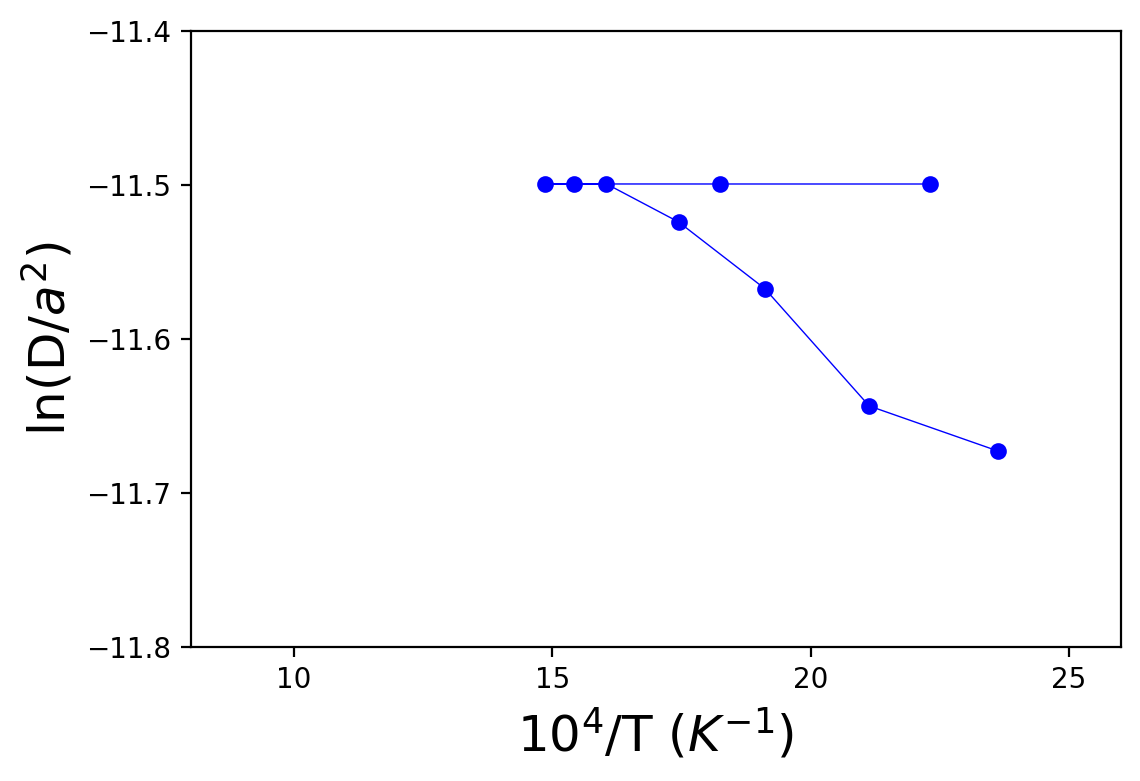

In [26]:
plt.figure(figsize = (6,4))
plt.xlabel(r'$10^{4}$/T ($K^{-1}$)')
plt.ylabel(r'ln(D/$a^{2}$)')
plt.xlim(8, 26)
plt.ylim(-11.8, -11.4)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

D_a2_array = arrhenius_list[0]

x_axis = D_a2_array[:, 0]
y_axis = D_a2_array[:, 1]

plt.plot(x_axis, y_axis, color = 'b', marker='o', linewidth=0.5, markersize=5)

plt.show()
